## **Flatiron Module 3 Project**  
**John Kline**    
***
12/08/19   
blog:   https://katahdin28.github.io/categorical_frequency_analysis  
git:   https://github.com/katahdin28/dsc-mod-3-project-online-ds-ft-100719  
review date:  tbd  

***

## Problem Statement  
  
This project presents us with the (simulated) data from a (fictional) company, Northwind, comprising of all Northwind's orders, customers, products, suppliers, and employees.  My goal is to evaluate one given relationship (between discount magnitude and order size) and to propose at least three other relationships to test.

## Statistical Relationshps to Evaluate (slash to-do list) 

1. **Does discount size have a statistically significant effect on order size? If so, at what level(s) of discount?**  
<br>  
2. **Does discount size have a significant effect on revenue per order?**  
<br>  
3. **Do German and American customers purchase the same types of goods?**
    - Germany and the US are the two largest customers
    - X person thinks they basically buy the same stuff
    - Y person thinks they have fundamentally different purchasing habits  
<br>  
4. TBD

    
## Goals

For each of the statistical relationships - I will lay out

- A summary of the data we're using to evaluate the relationship
    - Table
    - Chart
- Statistical test results
    - P-values or equivalent statistics
    - Confidence intervals
- Graphical depiction of test results

# Table of Contents
- Database Cleaning & Structuring

***

# Database Cleaning & Structuring

Connecting to the sqlite database and importing libraries

In [ ]:
import pandas as pd
pd.set_option("display.precision", 3)
pd.set_option("display.expand_frame_repr", False)
pd.set_option("display.max_rows", 25)

import seaborn as sns
import math
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import seaborn as sns
%matplotlib inline
import numpy as np
import sqlite3

conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()


### Database Structure Cleanup
- Changed table titled 'Order' to 'OrderInfo' because the first name was throwing errors
- Dropped two entirely empty tables - CustomerCustomerDemo and CustomerDemographics
- Changed order index column name to be actually matched between the two order tables


In [177]:
#cur.execute("""
#    ALTER TABLE 'Order'
#    RENAME TO OrderInfo
#    ;""")

#cur.execute("""
#    DROP TABLE CustomerCustomerDemo;""")

#cur.execute("""
#    DROP TABLE CustomerDemographic;""")

#cur.execute("""
#    ALTER TABLE 'OrderInfo'
#    RENAME COLUMN 'Id' TO 'OrderId';
#    ;""")

#cur.executescript("""
#    ALTER TABLE 'Product'
#    RENAME COLUMN 'UnitPrice' TO 'UnitPrice2';
#    ;""")

### Navigation among tables and columns
- Created a list **master_table_list** which lists all tables in the database
- Created a dictionary **master_table_dict**- where each key is a table name and each value is a list of indices in that table

In [16]:
def listify_tables(cur):
    """
    Takes sqlite3 cursor object and returns a list of table names
    """
    cur.execute("""
        SELECT name FROM sqlite_master 
        WHERE type='table' 
        ORDER BY name
        ;""")
    table_list = pd.DataFrame(cur.fetchall())[0].tolist()
    return table_list
    
    
def listify_indices(cur,tablename):
    """
    Takes sqlite cursor object and string-type table name, returns a list of indices
    """
    cur.execute(f"""PRAGMA table_info({tablename});""")
    table_indices = pd.DataFrame(cur.fetchall())[1].tolist()
    return table_indices

In [17]:
table_list = listify_tables(cur)

master_table_dict = {}

for table in table_list:
    master_table_dict[table] = listify_indices(cur,table) 

### Pulling a table from sqlite

In [18]:
def return_table_dataframe(tablename):
    
    """
    Returns a dataframe from an SQLITE table with correct column headers
    
    Takes one argument - a string name of a table in the SQLITE database
    """
    
    cur.execute(f"""
        SELECT * FROM {tablename} 
        ;""")
    df = pd.DataFrame(cur.fetchall())
    df.columns = master_table_dict[tablename]
    return df


In [85]:
# Printing out tables and their info / describe summaries to check for missing data

def show_table(table_name):
    print('---'*20)
    print(table_name)
    print('---'*20)
    print('    Info')
    print('...'*20)
    print(return_table_dataframe(table_name).info())
    print('...'*20)
    print('    Describe')
    print('...'*20)
    print(return_table_dataframe(table_name).describe())
    pass

for table in table_list:
    show_table(table)
    



------------------------------------------------------------
Category
------------------------------------------------------------
    Info
............................................................
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 3 columns):
Id              8 non-null int64
CategoryName    8 non-null object
Description     8 non-null object
dtypes: int64(1), object(2)
memory usage: 272.0+ bytes
None
............................................................
    Describe
............................................................
          Id
count  8.000
mean   4.500
std    2.449
min    1.000
25%    2.750
50%    4.500
75%    6.250
max    8.000
------------------------------------------------------------
Customer
------------------------------------------------------------
    Info
............................................................
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (t

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 2 columns):
Id                   4 non-null int64
RegionDescription    4 non-null object
dtypes: int64(1), object(1)
memory usage: 144.0+ bytes
None
............................................................
    Describe
............................................................
          Id
count  4.000
mean   2.500
std    1.291
min    1.000
25%    1.750
50%    2.500
75%    3.250
max    4.000
------------------------------------------------------------
Shipper
------------------------------------------------------------
    Info
............................................................
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
Id             3 non-null int64
CompanyName    3 non-null object
Phone          3 non-null object
dtypes: int64(1), object(2)
memory usage: 152.0+ bytes
None
.....................................................

Potential Data Issues list:
- OrdersInfo
    - ShippedDate - 809 of 830 items have shipped dates, 21 missing
    - ShipPostalCode - 811 of 830 items have postal codes, 19 missing
- Customer
    - One customer doesn't have a zip code (might explain the ship postal codes missing)
    
**No major data issues -- we likely will not use shipping dates or postal codes**

***

# 1. Evaluating effect of discount on order quantity

### Calling and Modifying Orders Table
- Pull in order table from SQLite database
- Adjust discount value from a decimal to integer values (i.e. each integer is 1% of discount)
- Created new baseline average value for each product - the average sales with no discount for the product
- Created new value - difference in sale quanity between the average no discount order size for the product and the order quantity

### Feature Engineering
- Created new baseline average value for each product - the average sales with no discount for the product
- Created new value for each order, **QuantityOverBaseline**- the difference in sale quantity between the average no-discount order size for the product and the individual order quantity. e.g.:
    - Product X has an average undiscounted order size of 20, and order #Y has a quantity of 25 - **QuantityOverBaseline** equals 5
    - Product S has an average undiscounted order size of 19.5 and order #T has a quantity of 18 - **QuantityOverBaseline** equals -1.5

In [21]:
# Moving relevant sql table to a dataframe
order = return_table_dataframe('OrderDetail')

# Making the discount values more intuitive to review
order['Discount'] = order['Discount']*100

# Creating new dictionary for each product and the average order quantity without a discount
def average_dict_withoutdiscount(df,column):
    baseline_sales = {}
    product_list = list(df['ProductId'].unique())
    for product in product_list:
        baseline_sales[product] = df.loc[(df['Discount']== 0) & (order['ProductId'] == product),[column]][column].mean()
    return(baseline_sales)

product_baseline_sales = average_dict_withoutdiscount(order,'Quantity')
#print(product_baseline_sales)

# Creating a new value for each order, "QuantityOverBaseline", which is the diff between the product no-discount avg and actual order
def from_dict(x):
    median = product_baseline_sales[x]
    return median

order['BaselineQuantity'] = order['ProductId'].apply(from_dict)
order['QuantityOverBaseline'] =  order['Quantity'] - order['BaselineQuantity']

# Alternate version logged
order['lnBaselineQuantity'] = np.log(order['BaselineQuantity'])
order['lnQuantity'] = np.log(order['Quantity'])
order['lnQuantityOverBaseline'] =  order['lnQuantity'] - order['lnBaselineQuantity']

order.head()

#pivot_table = order.pivot_table(index = 'ProductId', columns='Discount', values = 'QuantityOverBaseline', aggfunc='sum')
#print(pivot_table)

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,BaselineQuantity,QuantityOverBaseline,lnBaselineQuantity,lnQuantity,lnQuantityOverBaseline
0,10248/11,10248,11,14.0,12,0.0,15.120,-3.120,2.716,2.485,-0.231
1,10248/42,10248,42,9.8,10,0.0,17.833,-7.833,2.881,2.303,-0.578
2,10248/72,10248,72,34.8,5,0.0,19.677,-14.677,2.979,1.609,-1.370
3,10249/14,10249,14,18.6,9,0.0,20.167,-11.167,3.004,2.197,-0.807
4,10249/51,10249,51,42.4,40,0.0,17.680,22.320,2.872,3.689,0.816


In [22]:
print(order['Discount'].value_counts())

0.0     1317
5.0      185
10.0     173
20.0     161
15.0     157
25.0     154
3.0        3
2.0        2
1.0        1
6.0        1
4.0        1
Name: Discount, dtype: int64


The number of observations for the non-multiple of 5 discount values are so low that we will ignore the results of these in our tests below.

In [23]:
def remove_values(df, column, value):
    return df.loc[df[column] != value]

discounts_to_remove = [1,2,3,4,6]

for discount in discounts_to_remove:
    order = remove_values(order, 'Discount', discount)
    
print(order['Discount'].value_counts())



0.0     1317
5.0      185
10.0     173
20.0     161
15.0     157
25.0     154
Name: Discount, dtype: int64


### Regression Attempt 1
- Originally regressed the QuantityOverBaseline value against 'Discount'
- Found very high p-values for the coefficient
- Relatively large skew and kurtosis values
    - skew of 1.7
    - kurtosis of 7.7
- Below will redo the regression with a log-transformed quantity over baseline to try to control for the skew

In [24]:
def olsregress(dataframe, outcome_name, list_of_dep_cols):
    
    formula = f'{outcome_name} ~ '
    formula = formula+list_of_dep_cols[0]
    for column in list_of_dep_cols[1:]:
        formula = f'{formula} + {column}'
    result = sm.ols(formula=formula, data=dataframe).fit()
    return result

olsregress(order,'QuantityOverBaseline',['Discount']).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     QuantityOverBaseline   R-squared:                       0.019
Model:                              OLS   Adj. R-squared:                  0.018
Method:                   Least Squares   F-statistic:                     41.06
Date:                  Fri, 13 Dec 2019   Prob (F-statistic):           1.81e-10
Time:                          10:38:19   Log-Likelihood:                -9340.0
No. Observations:                  2147   AIC:                         1.868e+04
Df Residuals:                      2145   BIC:                         1.870e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5529      0.488      1.133      0.257      -0.404       1.510
Discount       0.3105      0.048      6.407      0.000       0.215       0.405
==============================================================================
Omnibus:                      770.213   Durbin-Watson:                   1.666
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3049.714
Skew:                           1.727   Prob(JB):                         0.00
Kurtosis:                       7.707   Cond. No.                         12.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Regression Attempt 2
- The p-values of the coefficient are very low - indicating a statistically significant relationship
- Our skew and kurtosis values are in an acceptable range
- The r-squared value of this is very low - 0.02, indicating that most of the quantity values are driven by factors orther than the discount value, despite the fact that the discount value is a factor with high confidence
- The magnitude of the coefficient on discount value indicates that for each percentage point increase in the discount value, the additional quantity sold per order increase by about ???? 1.5%

**As we will examine further on - one of the reasons this regression seems to have such a low p-value combined with a very small r-squared value, is that it apears that while having a discount is very predictive of higher order quantities, the order quantity has a high variance and the size of the discount does not seem to produce significantly higher order quantities.  Each discount level yields approximately the same boost to per-order quantities.

In [25]:
olsregress(order,'lnQuantityOverBaseline',['Discount']).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     lnQuantityOverBaseline   R-squared:                       0.020
Model:                                OLS   Adj. R-squared:                  0.020
Method:                     Least Squares   F-statistic:                     44.74
Date:                    Fri, 13 Dec 2019   Prob (F-statistic):           2.86e-11
Time:                            10:38:22   Log-Likelihood:                -2703.3
No. Observations:                    2147   AIC:                             5411.
Df Residuals:                        2145   BIC:                             5422.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2835      0.022    -12.779      0.000      -0.327      -0.240
Discount       0.0147      0.002      6.689      0.000       0.010       0.019
==============================================================================
Omnibus:                      115.442   Durbin-Watson:                   1.645
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              134.458
Skew:                          -0.577   Prob(JB):                     6.35e-30
Kurtosis:                       3.416   Cond. No.                         12.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Statistical Testing & Graphing

- First, graphing the two overlaid histogram plots for discounted and undiscounted data to see if there is an obvious visual pattern: **There is - clearly discounted items have a higher frequency of high order values than low order values**
- A pure bar chart is difficult to read - so I've put together a CDF comparison as well as PDF comparisons for each discount value
    - **Clear pattern here - higher order quantities for every single discount value** both from the mean difference between the groups and the overall graph shape
    - However - the higher discount values do not seem to correspond to greater product size than lower discount values

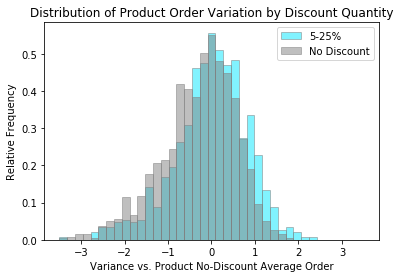

In [26]:
# Two overlaid histogram plots - one for undiscounted order quantities and one for discounted (expressed in log units)

bins = np.linspace(-3.5, 3.5, 40)

plt.hist(list(order.loc[order['Discount']>=5.0,['lnQuantityOverBaseline']]['lnQuantityOverBaseline']), bins, alpha=0.5, label='5-25%', density=True, edgecolor='.5', fc="#05E9FF", lw=1)
plt.hist(list(order.loc[order['Discount']==0.0,['lnQuantityOverBaseline']]['lnQuantityOverBaseline']), bins, alpha=0.5, label='No Discount', density=True, edgecolor='0.5', fc="0.5", lw=1)

plt.legend(loc='upper right')
plt.title('Distribution of Product Order Variation by Discount Quantity')
plt.ylabel('Relative Frequency')
plt.xlabel('Variance vs. Product No-Discount Average Order')
plt.show()

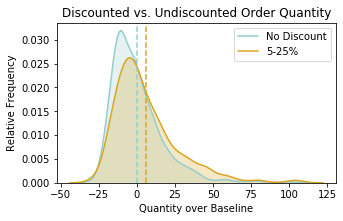

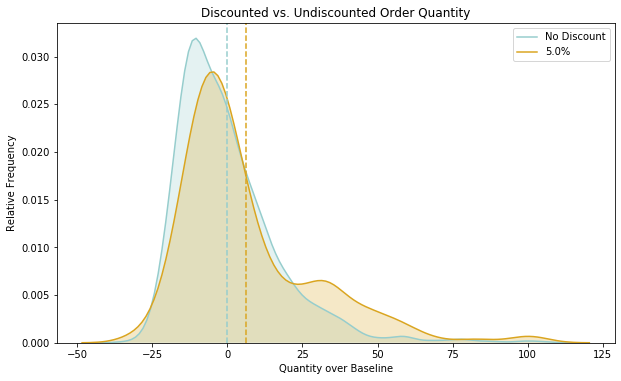

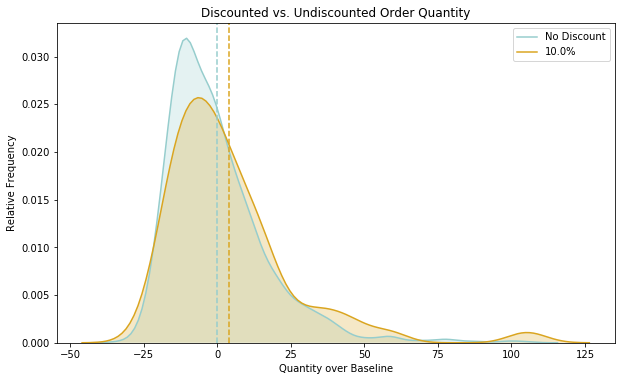

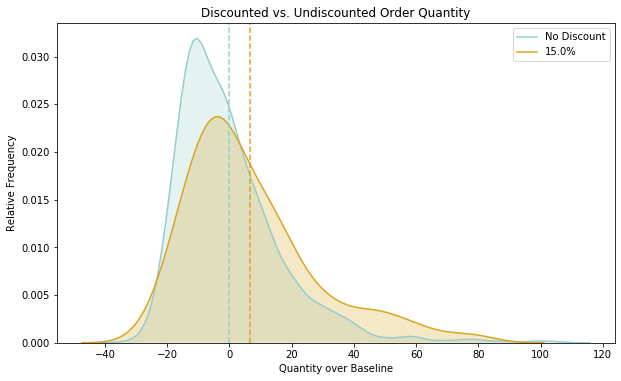

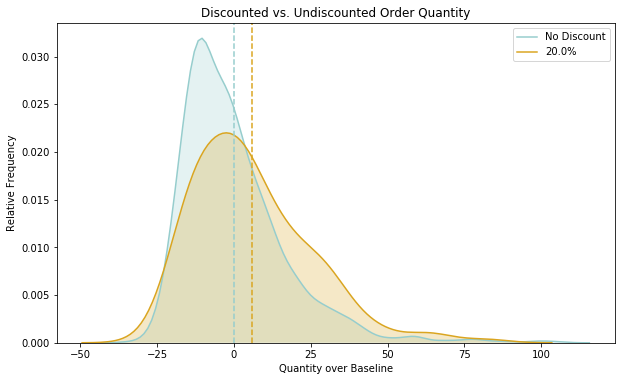

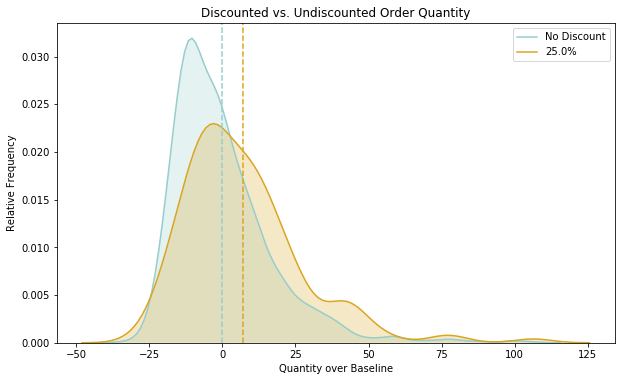

In [187]:
# Two overlaid kernel density plots - one for undiscounted order quantities and one for discounted (expressed in log units)
def discount_data(discount):
    return list(order.loc[order['Discount']==discount,['QuantityOverBaseline']]['QuantityOverBaseline'])

all_discount_data = order.loc[order['Discount']>=5.0,['QuantityOverBaseline']]['QuantityOverBaseline']

def kde_pair_comparison(data1, data2, label1, label2, graph_title, x_title, cum_bool, graph_size):
    plt.figure(figsize=(graph_size,graph_size/1.7))
    sns.kdeplot(data1, shade = True, label=label1, cumulative = cum_bool, color = '#96CDCD')
    sns.kdeplot(data2, shade = True, label=label2, cumulative = cum_bool, color = 'goldenrod')
    
    plt.axvline(x=np.mean(data1), color = '#96CDCD', linestyle="--")
    plt.axvline(x=np.mean(data2), color = 'goldenrod', linestyle="--")
    plt.legend(loc='upper right')
    plt.title(graph_title)
    plt.ylabel('Relative Frequency')
    plt.xlabel(x_title)
    plt.show()
    pass


discount_list=[5.0,10.0,15.0,20.0,25.0]
baseline_data = discount_data(0.0)
all_discount_data = list(order.loc[order['Discount']>=5.0,['QuantityOverBaseline']]['QuantityOverBaseline'])

kde_pair_comparison(baseline_data, all_discount_data, label1 = 'No Discount', label2 = '5-25%', graph_title = 'Discounted vs. Undiscounted Order Quantity', x_title = 'Quantity over Baseline', cum_bool = False, graph_size = 5)

for discount in discount_list:
    kde_pair_comparison(baseline_data, discount_data(discount), label1 = 'No Discount', label2 = str(discount)+'%', graph_title = 'Discounted vs. Undiscounted Order Quantity', x_title = 'Quantity over Baseline', cum_bool = False, graph_size = 10)

In [28]:
discount_list=[0.0,5.0,10.0,15.0,20.0,25.0]

def pull_order_tot(discount):
    return order.loc[(order['Discount']== discount),['Quantity']]['Quantity'].sum()

def pull_diff_avg(discount):
    return order.loc[(order['Discount']== discount),['QuantityOverBaseline']]['QuantityOverBaseline'].mean()

def pull_diff_tot(discount):
    return order.loc[(order['Discount']== discount),['QuantityOverBaseline']]['QuantityOverBaseline'].sum()

def pull_order_avg(discount):
    return order.loc[(order['Discount']== discount),['Quantity']]['Quantity'].mean()

df_discount_summary= pd.DataFrame()
df_discount_summary['Discount%'] = discount_list
df_discount_summary['OrderTotal'] = df_discount_summary['Discount%'].apply(pull_order_tot)
df_discount_summary['OrderDiffTotal'] = round(df_discount_summary['Discount%'].apply(pull_diff_tot),0)
df_discount_summary['OrderAverage'] = df_discount_summary['Discount%'].apply(pull_order_avg)
df_discount_summary['OrderDiff'] = round(df_discount_summary['Discount%'].apply(pull_diff_avg),2)
df_discount_summary['Diff%'] = round(100*df_discount_summary['OrderDiffTotal']/(df_discount_summary['OrderTotal']),2)
print(df_discount_summary)

#Look at distribution of products that are included vs. not included in the discounted products - is there a distribution
#time of year?
#are some employees better at selling than others
#per-customer anova by product - are they pulling statistically unusual product quantities

   Discount%  OrderTotal  OrderDiffTotal  OrderAverage  OrderDiff  Diff%
0        0.0       28599             0.0        21.715       0.00   0.00
1        5.0        5182          1170.0        28.011       6.32  22.58
2       10.0        4366           698.0        25.237       4.04  15.99
3       15.0        4456          1054.0        28.382       6.71  23.65
4       20.0        4351           941.0        27.025       5.84  21.63
5       25.0        4349          1075.0        28.240       6.98  24.72


In the table above we've shown the 5 discount levels that account for 99.9% of orders with a discount granted, as well as all undiscounted orders. For all of these discount levels we see a significant increase in the quantity per order when there is a discount for a given product vs. when there is no discount for the product.
- **The percent of orders coming from additional ordering quantity due to discounts on products is significant and consistently high across discount levels - ranging from 16% to 25%**
- **However, the actual order increase is consistent across discount levels, aside form 10% which underperforms, and does not grow with discount size*
- The implied additional revenue from the discounts drops as the discount value increases - e.g. the increased sales don't keep pace with the increased discounts.  These numbers are crude and not exact because there could be a range of prices across products.  
    - At 5% discount - the additional orders from discounts is more than 22% of total orders for 5% discounted products, while the loss in revenue is only 5%
    - At 25% discount - the additional orders from discounts is 24.7%, while the loss in revenue is 25%, so we should see an approximately breakeven impact on revenue.  However, if there are any per-unit costs of goods sold, we should see a greater than 25% drop in profits for these discounted products, so this discount level may decrease profits for this tranche of sales. Particularly if the per-unit cost of goods sold is greater than 75%, the discount would entirely erase gross profits for this tranche of sales while not increasing revenue at all.
    
### Below - we will test whether the visual / summary results statistically significant or possibly due to random chance
- One-Way ANOVA test for significance of any discount value
- If successful - a tukey test for which ones are significant

In [32]:

f, p = stats.f_oneway(order[order['Discount'] == 0.0].QuantityOverBaseline,
                      order[order['Discount'] == 5.0].QuantityOverBaseline,
                      order[order['Discount'] == 10.0].QuantityOverBaseline,
                      order[order['Discount'] == 15.0].QuantityOverBaseline,
                      order[order['Discount'] == 20.0].QuantityOverBaseline,
                      order[order['Discount'] == 25.0].QuantityOverBaseline)
 
print ('One-way ANOVA')
 
print ('F value:', round(f,2))
print ('P value:', round(p,5), '\n')


One-way ANOVA
F value: 10.8
P value: 0.0 



From this ANOVA test we can conclude that at least one of the discount levels' relative order size is statistically different from the mean of the other discount levels'. We'll run the Tukey test to isolate which combinations are worth looking into.

In [39]:
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd

mc = MultiComparison(order['QuantityOverBaseline'], order['Discount'])
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    5.0   6.3231  0.001  2.1302 10.5159   True
   0.0   10.0   4.0363 0.0829 -0.2822  8.3548  False
   0.0   15.0   6.7106  0.001  2.2018 11.2194   True
   0.0   20.0   5.8427 0.0026  1.3842 10.3012   True
   0.0   25.0   6.9813  0.001  2.4334 11.5292   True
   5.0   10.0  -2.2868 0.8419 -7.9347  3.3611  False
   5.0   15.0   0.3876    0.9 -5.4072  6.1823  False
   5.0   20.0  -0.4803    0.9  -6.236  5.2753  False
   5.0   25.0   0.6583    0.9 -5.1669  6.4834  False
  10.0   15.0   2.6743 0.7605 -3.2119  8.5606  False
  10.0   20.0   1.8065    0.9 -4.0413  7.6543  False
  10.0   25.0    2.945 0.6889 -2.9712  8.8613  False
  15.0   20.0  -0.8679    0.9 -6.8576  5.1218  False
  15.0   25.0   0.2707    0.9 -5.7858  6.3272  False
  20.0   25.0   1.1386    0.9 -4.8806  7.1578  False
----------------------------------------------

Using the Tukey test we ran above, we can tell exactly which discount levels are statistically significant.  Our results indicate that 5%, 15%, 20%, and 25% discount levels are drive higher per-order sales volume on a relative product basis.

Discussion points:
- The p-values are low for the statistically significant discount levels (<.01), but the confidence intervals are wide - ranging from 1 to 10 or 12, with a mean of ~6.  Therefore, we can't say with great certainty the exact impact. 
- We are not able to determine whether or not a 25% discount level drives more sales than a 5% discount level - there is not a statistically significant difference in the mean of the additional orers between any of the statistically significant discount levels
- Some of these issues may be resolved through extended data collection.  For example - the 10% discount level not being statistically significant is an inexplicable gap - however, the confidence interval for this group is bounded by -.8 and 9, very much the same pattern as the other discounts, but with a lower mean.  More data points could tighten this interval and give us a statistically significant result.
- We've ignored the 6, 1, 2, 3, 4% discount levels as they have a max of 3 observations per group (vs. 100s and 1000s in the other groups)

## Recommendations
- Discounts work well - they drive sales increases of 15-25%
- We don't have evidence that higher discounts drive meaningfully larger sales volume than smaller discounts - **rely on smaller discounts (5%) rather than larger (15%+)
    - This could bear further study with a larger data set - over a longer period of time, we may find patterns across discount levels
    - We would expect revenue to be maximized at the 5% discount level.

## Now lets do revenue per order instead of order size

In [41]:
# Creating new order - revenue table where we'll calculate revenue
order_rev = order[['Id','OrderId','ProductId','UnitPrice','Quantity','Discount']]

# We need to multiply quantity times unitprice, with discounts removed to get to actual realized revenue
order_rev['Revenue'] = (order_rev['Quantity'] * order_rev['UnitPrice'])*(1-order_rev['Discount']/100)

print("The unit price varies significantly even at the - 0% discount level")
print(order_rev.loc[(order_rev['ProductId'] == 11) & (order_rev['Discount'] == 0.0)])

# Creating new dictionary for each product and the average order quantity without a discount
product_baseline_revenue = average_dict_withoutdiscount(order_rev, 'Revenue')

# Creating a new value for each order, "QuantityOverBaseline", which is the diff between the product no-discount avg and actual order
def from_dict_rev(x):
    mean = product_baseline_revenue[x]
    return mean

order_rev['BaselineRev'] = order_rev['ProductId'].apply(from_dict_rev)
order_rev['RevOverBaseline'] =  order_rev['Revenue'] - order_rev['BaselineRev']

order_rev.head()


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


The unit price varies significantly even at the - 0% discount level
            Id  OrderId  ProductId  UnitPrice  Quantity  Discount  Revenue
0     10248/11    10248         11       14.0        12       0.0    168.0
129   10296/11    10296         11       16.8        12       0.0    201.6
313   10365/11    10365         11       16.8        24       0.0    403.2
425   10407/11    10407         11       16.8        30       0.0    504.0
491   10434/11    10434         11       16.8         6       0.0    100.8
513   10442/11    10442         11       16.8        30       0.0    504.0
582   10466/11    10466         11       16.8        10       0.0    168.0
631   10486/11    10486         11       16.8         5       0.0     84.0
742   10528/11    10528         11       21.0         3       0.0     63.0
794   10545/11    10545         11       21.0        10       0.0    210.0
814   10553/11    10553         11       21.0        15       0.0    315.0
967   10614/11    10614         

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Revenue,BaselineRev,RevOverBaseline
0,10248/11,10248,11,14.0,12,0.0,168.0,294.504,-126.504
1,10248/42,10248,42,9.8,10,0.0,98.0,236.911,-138.911
2,10248/72,10248,72,34.8,5,0.0,174.0,635.323,-461.323
3,10249/14,10249,14,18.6,9,0.0,167.4,429.350,-261.950
4,10249/51,10249,51,42.4,40,0.0,1696.0,892.096,803.904


570.0065375854215
797.9317540540541
528.8967572254332
557.3641656050955
553.919900621118
642.4582305194806


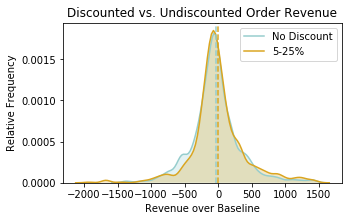

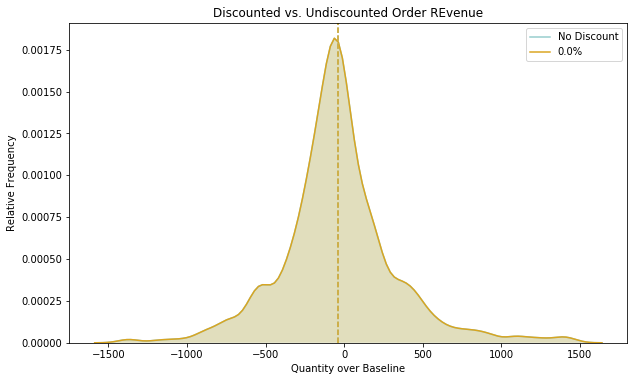

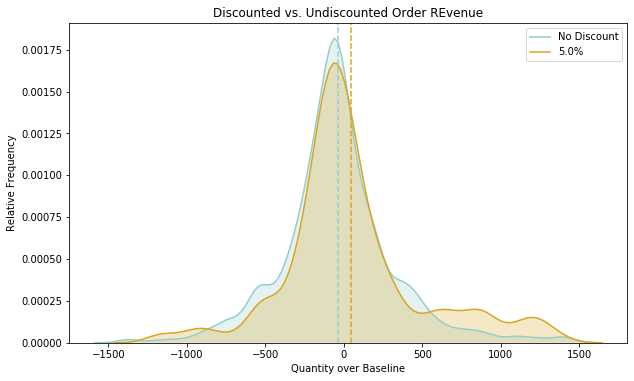

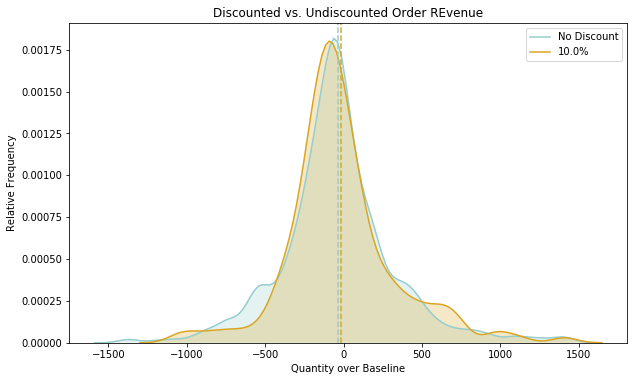

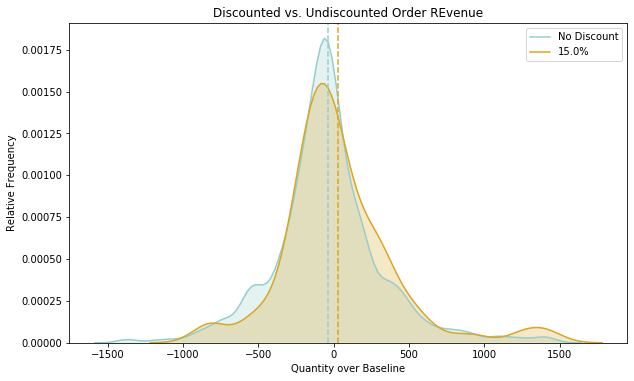

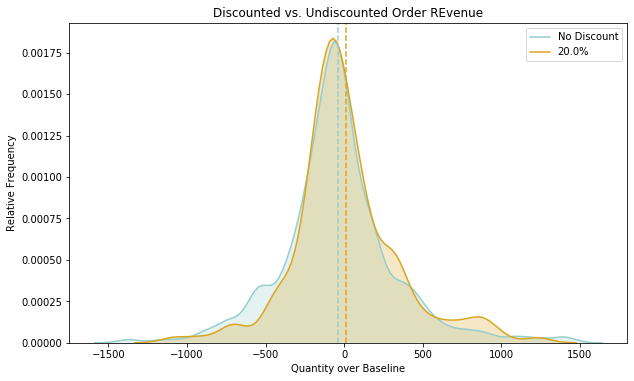

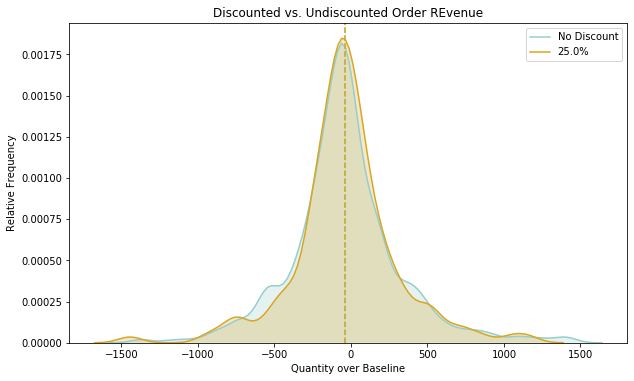

In [191]:
def discount_revenue(discount):
    return list(order_rev.loc[(order_rev['Discount']==discount) & (order_rev['RevOverBaseline']>= -1500) &(order_rev['RevOverBaseline']<=1500),['RevOverBaseline']]['RevOverBaseline'])

discount_list=[0.0,5.0,10.0,15.0,20.0,25.0]

for item in discount_list:
    print(order_rev.loc[(order['Discount']==item),'Revenue'].mean())

baseline_revenue = discount_revenue(0.0)
all_discount_revenue = list(order_rev.loc[(order['Discount']>=5.0) & (order_rev['RevOverBaseline']>= -2000) &(order_rev['RevOverBaseline']<=1500),['RevOverBaseline']]['RevOverBaseline'])

kde_pair_comparison(baseline_revenue, all_discount_revenue, label1 = 'No Discount', label2 = '5-25%', graph_title = 'Discounted vs. Undiscounted Order Revenue', x_title = 'Revenue over Baseline', cum_bool = False, graph_size = 5)

for discount in discount_list:
    kde_pair_comparison(baseline_revenue, discount_revenue(discount), label1 = 'No Discount', label2 = str(discount)+'%', graph_title = 'Discounted vs. Undiscounted Order REvenue', x_title = 'Quantity over Baseline', cum_bool = False, graph_size = 10)

In [43]:
f2, p2 = stats.f_oneway(order_rev[order_rev['Discount'] == 0.0].RevOverBaseline,
                        order_rev[order_rev['Discount'] == 5.0].RevOverBaseline,
                        order_rev[order_rev['Discount'] == 10.0].RevOverBaseline,
                        order_rev[order_rev['Discount'] == 15.0].RevOverBaseline,
                        order_rev[order_rev['Discount'] == 20.0].RevOverBaseline,
                        order_rev[order_rev['Discount'] == 25.0].RevOverBaseline)
 
print ('One-way ANOVA')
 
print ('F value:', round(f2,2))
print ('P value:', round(p2,5), '\n')


One-way ANOVA
F value: 1.33
P value: 0.24765 



None of the discount values raise per-order revenue to a level of statistical significance based on the One-way ANOVA test.  We'll run the tukey test below to confirm / see which ones are closest to passing.

In [129]:
mc = MultiComparison(order_rev['RevOverBaseline'], order_rev['Discount'])
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower    upper   reject
--------------------------------------------------------
   0.0    5.0   123.817 0.1924  -29.4202 277.0543  False
   0.0   10.0   -3.9153    0.9 -161.7437 153.9132  False
   0.0   15.0    65.457 0.8545  -99.3267 230.2407  False
   0.0   20.0   42.6894    0.9  -120.255 205.6338  False
   0.0   25.0   45.0382    0.9 -121.1734 211.2497  False
   5.0   10.0 -127.7323 0.4891  -334.147  78.6825  False
   5.0   15.0    -58.36    0.9 -270.1403 153.4203  False
   5.0   20.0  -81.1276 0.8735 -291.4799 129.2248  False
   5.0   25.0  -78.7788 0.8992  -291.672 134.1144  False
  10.0   15.0   69.3723    0.9 -145.7534 284.4979  False
  10.0   20.0   46.6047    0.9 -167.1154 260.3248  False
  10.0   25.0   48.9534    0.9 -167.2679 265.1748  False
  15.0   20.0  -22.7676    0.9 -241.6742  196.139  False
  15.0   25.0  -20.4188    0.9 -241.7681 200.9305  False
  20.0   25.0    2.3488    0.9 

## Discussion
- Unlike sales volume per order, revenue per order does not increase as discounts are applied to a level that meets statistical significance.
    - Key contributing factors are the additional variability in unit price within product categories, even without any discount, which is either (1) obscuring the relationship betweeen sales revenue and discount or (2) erasing / cutting against the relationship between sales volume and discount value (e.g. mark up to mark down)
    - 

## Recommendations
- Investigate source of price variations - are these due to price changes over time, which correlate to the introduction of different discounts?  Are discounts only applied to overpriced items or items for certain regions / clients?
- Evaluate whether discounts make sense to offer - they may have promotional / marketing value beyond their impact on revenue, or they may be useful even at breakeven to move seasonal inventory.


## Hypothesis - German and US customers purchase the same kinds of goods

In [69]:
# Joining Order, Product, Category tables to get consolidated data needed for the anlaysis
cur.execute("""
    SELECT * FROM OrderDetail O
    JOIN OrderInfo I ON O.OrderId = I.OrderId
    JOIN Product P ON O.ProductId = P.Id
    JOIN Category C ON P.CategoryId = C.Id
    ;""")

df_order_country = pd.DataFrame(cur.fetchall())
df_order_country.columns = [i[0] for i in cur.description]

# Narrowing table to just US and German customers
df_order_usger = df_order_country.loc[(df_order_country['ShipCountry']=='USA') | (df_order_country['ShipCountry']=='Germany')]

# Summary Pivot table to review
df_usger_pivot = pd.pivot_table(df_order_usger, values = 'Quantity', index = 'CategoryName', columns = 'ShipCountry', aggfunc=np.sum, fill_value=0)

def pivot_chi_sq(pivot_table, title):
    print(title)
    print('............................')
    print(pivot_table)

    results = stats.chi2_contingency(pivot_table)
    print('----Chi-Sq P-Value-----')
    print(round(results[1],4))
    print('---------\n')
    pass

pivot_chi_sq(df_usger_pivot, 'All Sales Categories by Sales Volume')



def remove_values(df, column, value):
    return df.loc[df[column] != value]

# Using Chi-Sq table to see if they are substantially different
# Commentary https://sites.google.com/a/lakeheadu.ca/bweaver/Home/statistics/notes/chisqr_assumptions
categories_to_remove = ['Meat/Poultry','Produce','Seafood','Dairy Products']
df_order_abridged = df_order_usger
for category in categories_to_remove:
    df_order_abridged = remove_values(df_order_abridged, 'CategoryName', category)


df_usger_pivot2 = pd.pivot_table(df_order_abridged, values = 'Quantity', index = 'CategoryName', columns = 'ShipCountry', aggfunc=np.sum, fill_value=0)
pivot_chi_sq(df_usger_pivot2, 'Abridged Sales Categories by Sales Volume')

All Sales Categories by Sales Volume
............................
ShipCountry     Germany   USA
CategoryName                 
Beverages          1691  1616
Condiments          869   821
Confections        1597  1602
Dairy Products     1800  1559
Grains/Cereals      800   730
Meat/Poultry        569  1157
Produce             488   321
Seafood            1399  1524
----Chi-Sq P-Value-----
0.0
---------

Abridged Sales Categories by Sales Volume
............................
ShipCountry     Germany   USA
CategoryName                 
Beverages          1691  1616
Condiments          869   821
Confections        1597  1602
Grains/Cereals      800   730
----Chi-Sq P-Value-----
0.4502
---------



The results of our Chi-Sq test indicate that Germany and the US purchase significantly different quantities of items (p=val <<.0001) - and this difference seems to be primarily driven by four of the eight categories:
- Meat / Poultry (almost 2x as much in the US)
- Produce
- Seafood
- Dairy Products

If we remove all items from these four categories, the chi-sq p-value test comes back with a p-value of .45 - statistically indistinguishable on the basis of beverage, condiment, confection, and grains / cereals consumption

In [174]:
def pivot_barplot(pivot_table, title):
    pivot_table['Cat_Diff'] = np.abs(pivot_table['Germany'] - pivot_table['USA'])
    pivot_table.sort_values('Cat_Diff', inplace = True, ascending = False)
    pivot_table[['Germany','USA']].plot.bar()
    plt.title(title)
    plt.show()
    pass



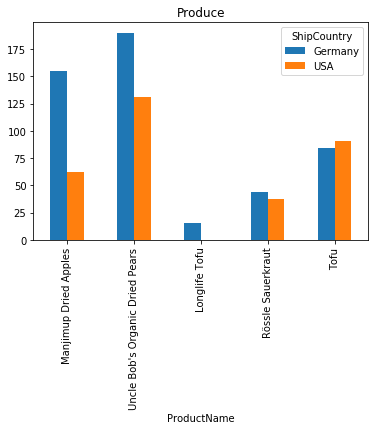

Produce
............................
ShipCountry                      Germany  USA
ProductName                                  
Manjimup Dried Apples                155   62
Uncle Bob's Organic Dried Pears      190  131
Longlife Tofu                         15    0
Rössle Sauerkraut                     44   37
Tofu                                  84   91
----Chi-Sq P-Value-----
0.0
---------



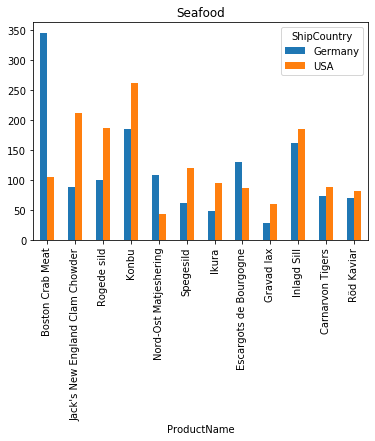

Seafood
............................
ShipCountry                      Germany  USA
ProductName                                  
Boston Crab Meat                     345  104
Jack's New England Clam Chowder       88  211
Rogede sild                          100  186
Konbu                                184  262
Nord-Ost Matjeshering                108   44
Spegesild                             62  120
Ikura                                 48   95
Escargots de Bourgogne               130   87
Gravad lax                            28   60
Inlagd Sill                          162  185
Carnarvon Tigers                      74   88
Röd Kaviar                            70   82
----Chi-Sq P-Value-----
0.0
---------



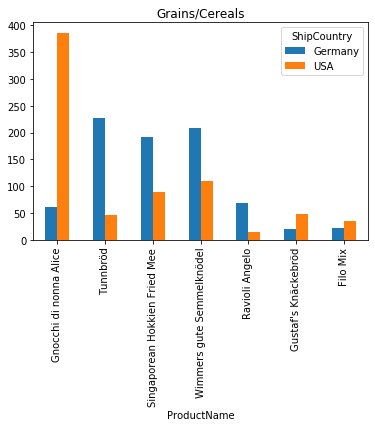

Grains/Cereals
............................
ShipCountry                    Germany  USA
ProductName                                
Gnocchi di nonna Alice              62  386
Tunnbröd                           227   46
Singaporean Hokkien Fried Mee      191   89
Wimmers gute Semmelknödel          208  110
Ravioli Angelo                      69   15
Gustaf's Knäckebröd                 20   48
Filo Mix                            23   36
----Chi-Sq P-Value-----
0.0
---------



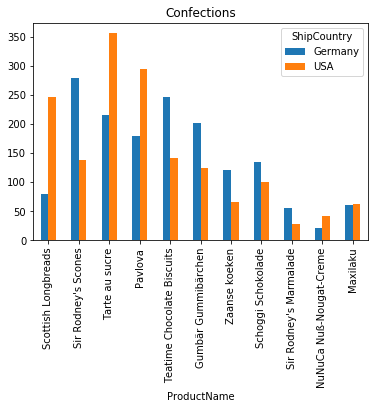

Confections
............................
ShipCountry                 Germany  USA
ProductName                             
Scottish Longbreads              79  247
Sir Rodney's Scones             280  139
Tarte au sucre                  215  356
Pavlova                         180  295
Teatime Chocolate Biscuits      246  141
Gumbär Gummibärchen             202  125
Zaanse koeken                   121   66
Schoggi Schokolade              135  100
Sir Rodney's Marmalade           56   28
NuNuCa Nuß-Nougat-Creme          22   42
Maxilaku                         61   63
----Chi-Sq P-Value-----
0.0
---------



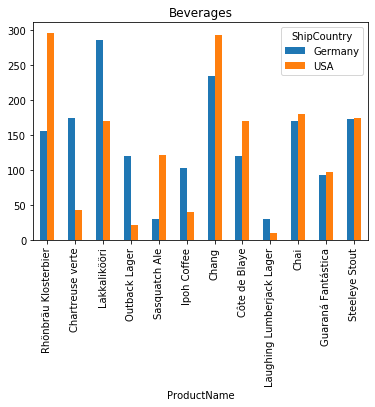

Beverages
............................
ShipCountry                Germany  USA
ProductName                            
Rhönbräu Klosterbier           156  297
Chartreuse verte               174   42
Lakkalikööri                   287  170
Outback Lager                  120   21
Sasquatch Ale                   30  122
Ipoh Coffee                    103   39
Chang                          235  294
Côte de Blaye                  120  170
Laughing Lumberjack Lager       30   10
Chai                           170  180
Guaraná Fantástica              93   97
Steeleye Stout                 173  174
----Chi-Sq P-Value-----
0.0
---------



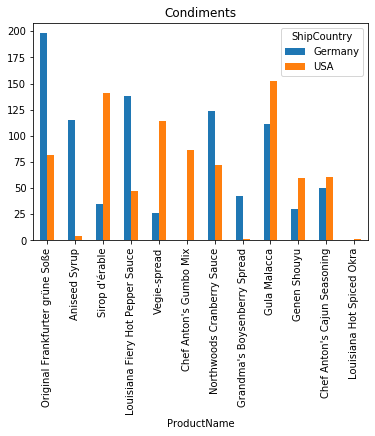

Condiments
............................
ShipCountry                       Germany  USA
ProductName                                   
Original Frankfurter grüne Soße       198   82
Aniseed Syrup                         115    4
Sirop d'érable                         35  141
Louisiana Fiery Hot Pepper Sauce      138   47
Vegie-spread                           26  114
Chef Anton's Gumbo Mix                  0   86
Northwoods Cranberry Sauce            124   72
Grandma's Boysenberry Spread           42    1
Gula Malacca                          111  152
Genen Shouyu                           30   60
Chef Anton's Cajun Seasoning           50   61
Louisiana Hot Spiced Okra               0    1
----Chi-Sq P-Value-----
0.0
---------



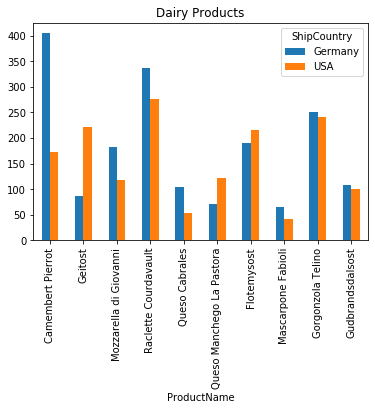

Dairy Products
............................
ShipCountry                Germany  USA
ProductName                            
Camembert Pierrot              405  173
Geitost                         86  221
Mozzarella di Giovanni         183  117
Raclette Courdavault           337  276
Queso Cabrales                 104   53
Queso Manchego La Pastora       71  122
Flotemysost                    190  215
Mascarpone Fabioli              65   41
Gorgonzola Telino              250  241
Gudbrandsdalsost               109  100
----Chi-Sq P-Value-----
0.0
---------



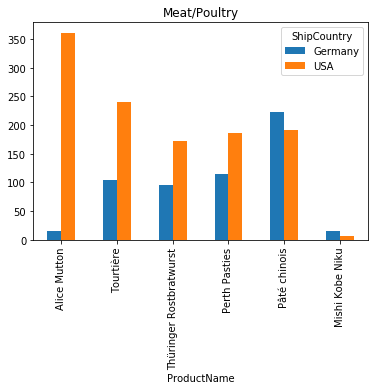

Meat/Poultry
............................
ShipCountry              Germany  USA
ProductName                          
Alice Mutton                  15  361
Tourtière                    104  240
Thüringer Rostbratwurst       96  173
Perth Pasties                115  186
Pâté chinois                 223  191
Mishi Kobe Niku               16    6
----Chi-Sq P-Value-----
0.0
---------



In [175]:
for category in list(df_order_usger['CategoryName'].unique()):
    pivot_table = pd.pivot_table(df_order_usger.loc[df_order_usger['CategoryName'] == category], values = 'Quantity', index = 'ProductName', columns = 'ShipCountry', aggfunc=np.sum, fill_value=0)
    pivot_barplot(pivot_table,category)
    pivot_chi_sq(pivot_table[['Germany','USA']], category)

    


## Summary
- At a broad category level, we have found that only a subset of sales categories were statistically indistinguishable from one another - Beverages, Condiments, Confections, and Grains / Cereals, while the remainder in total were statistically unlikely to have occured by random
- However - drilling down into individual produts, we do not find that the pattern of purchase was similar between Germany and the US
- We can reject our advisors opinion that the US and Germany have similar product purchase patterns

## Recommendations
- lkjas
- slkdj
- lksd

# Which employees are the best salespeople
- Volume
- Revenue
- Regionality

In [184]:
# Joining Order, Product, Category tables to get consolidated data needed for the anlaysis
cur.execute("""
    SELECT * FROM OrderDetail O
    JOIN OrderInfo I ON O.OrderId = I.OrderId
    JOIN Product P ON O.ProductId = P.Id
    JOIN Employee E ON I.EmployeeId = E.Id
    ;""")

df_order_employee = pd.DataFrame(cur.fetchall())
df_order_employee.columns = [i[0] for i in cur.description]
df_order_employee_abridged = df_order_employee[['Quantity', 'UnitPrice','Discount','CategoryId','FirstName','LastName','OrderDate']]
df_order_employee_abridged['Revenue'] = round(df_order_employee_abridged['UnitPrice'] * df_order_employee_abridged['Quantity'] * (1-df_order_employee_abridged['Discount']/100),2)

employee_pivot_quantity = pd.pivot_table(df_order_employee_abridged, values = 'Quantity', columns = 'LastName', aggfunc=np.sum, fill_value=0)
print(employee_pivot_quantity)

employee_pivot_revenue = pd.pivot_table(df_order_employee_abridged, values = 'Revenue', columns = 'LastName', aggfunc=np.sum, fill_value=0)
print(employee_pivot_revenue)



LastName  Buchanan  Callahan  Davolio  Dodsworth  Fuller  King  Leverling  Peacock  Suyama
Quantity      3036      5913     7812       2670    6055  4654       7852     9798    3527
LastName  Buchanan   Callahan    Davolio  Dodsworth     Fuller       King  Leverling    Peacock    Suyama
Revenue    75500.0  133236.68  202043.37    82907.5  177637.16  141128.68  212948.95  250014.46  78155.24


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
 Buchanan  Callahan  -3.2064 0.8306   -9.774 3.3612  False
 Buchanan   Davolio  -3.3052 0.7639  -9.6168 3.0063  False
 Buchanan Dodsworth  -0.9954    0.9  -8.8869  6.896  False
 Buchanan    Fuller  -0.8242    0.9  -7.4717 5.8233  False
 Buchanan      King   0.4945    0.9  -6.5428 7.5317  False
 Buchanan Leverling  -1.4877    0.9  -7.8587 4.8834  False
 Buchanan   Peacock  -2.6201    0.9  -8.7873  3.547  False
 Buchanan    Suyama  -4.9547 0.4318 -12.0585 2.1492  False
 Callahan   Davolio  -0.0988    0.9  -4.9439 4.7462  False
 Callahan Dodsworth    2.211    0.9   -4.565  8.987  False
 Callahan    Fuller   2.3822 0.8996  -2.8931 7.6574  False
 Callahan      King   3.7009   0.54  -2.0577 9.4595  False
 Callahan Leverling   1.7188    0.9  -3.2035  6.641  False
 Callahan   Peacock   0.5863    0.9  -4.0692 5.2417  Fal